In [ ]:
!pip install --upgrade tensorflow

In [ ]:
import sys
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import drive

if 'google.colab' in sys.modules:
    print("setting tensorflow version in colab")
print(tf.__version__)

drive.mount('/content/drive')

setting tensorflow version in colab
2.16.1
Mounted at /content/drive


In [ ]:
# Cargar datos desde un archivo Excel, parsear las fechas y establecer la columna 'date' como índice
dataset = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Monografía/datos_arbei/Datos_monografía.xlsx',
                        index_col=0, date_format='%Y %m %d')
dataset.index.name = 'date'
dataset.index = pd.to_datetime(dataset.index)
dataset = dataset[['ndvi', 'precipitation', 'soil_moisture', 'recharge']]

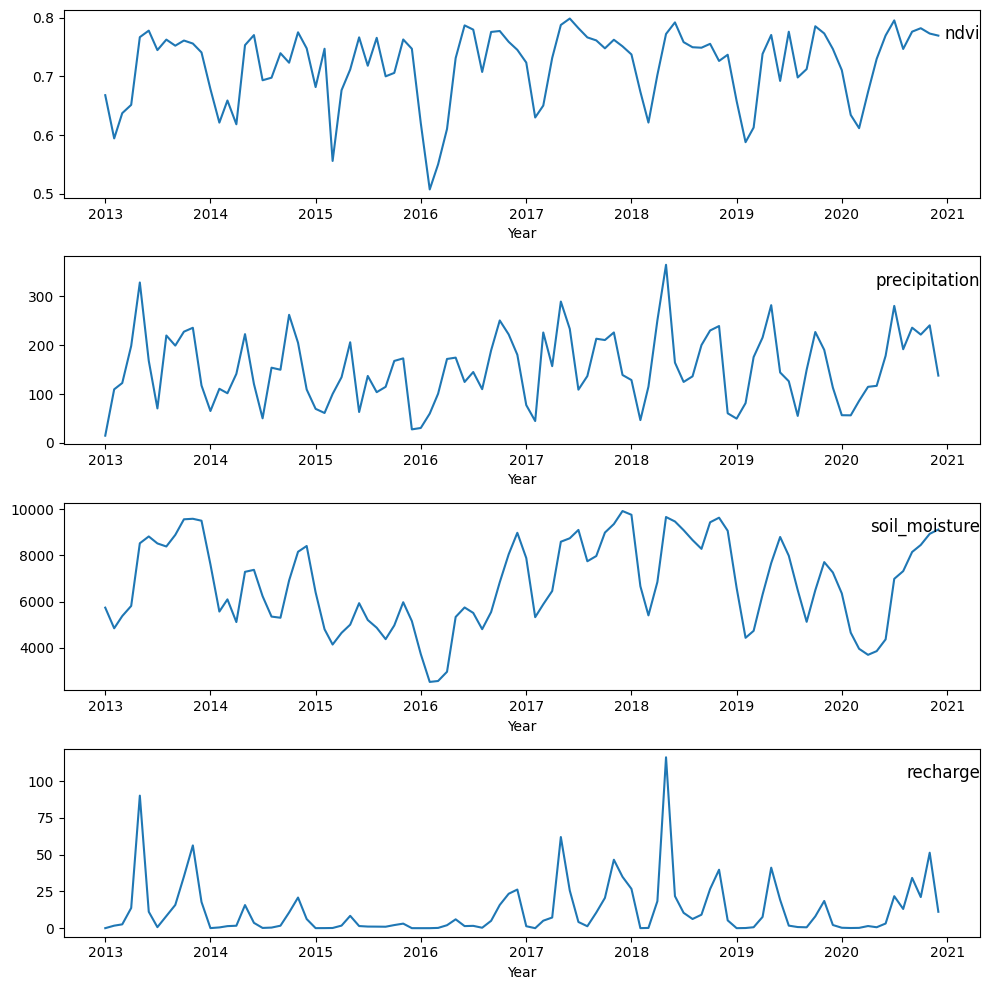

In [ ]:
# Visualización de datos
groups = [0, 1, 2, 3]
plt.figure(figsize=(10, 10))
for i, group in enumerate(groups):
    plt.subplot(len(groups), 1, i + 1)
    plt.plot(dataset.index, dataset.iloc[:, group])
    plt.title(dataset.columns[group], y=0.8, loc='right')
    plt.xlabel('Year')
plt.tight_layout()
plt.show()

In [ ]:
def create_sequences(data, n_past_steps=1, n_forecast_steps=1, n_overlay_steps=1, include_target_as_feature=False):
    x_sequence = []
    y_sequence = []
    start_idx = 0

    while True:
        end_idx = start_idx + n_past_steps
        forecast_end_idx = end_idx + n_forecast_steps

        if forecast_end_idx > len(data):
            break

        if include_target_as_feature:
            x = data[start_idx:end_idx]  # Usar todas las columnas excepto la de fecha
        else:
            x = data[start_idx:end_idx, 1:]  # Ignorar la columna de fecha y la columna objetivo
        y = data[end_idx:forecast_end_idx, 0]  # La columna objetivo es 'ndvi'
        x_sequence.append(x)
        y_sequence.append(y)

        start_idx += n_overlay_steps

    return np.array(x_sequence), np.array(y_sequence)

In [ ]:
n_past_steps = 1
n_forecast_steps = 1
n_overlay_steps = 1
n_features = 3

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset.values)

# División en datos de entrenamiento y prueba
train_size = int(len(dataset) * 0.8)
train_scaled = dataset_scaled[:train_size]
test_scaled = dataset_scaled[train_size:]

# Creación de secuencias
X_all, y_all = create_sequences(dataset_scaled, n_past_steps, n_forecast_steps, n_overlay_steps)
X_train, y_train = create_sequences(train_scaled, n_past_steps, n_forecast_steps, n_overlay_steps)
X_test, y_test = create_sequences(test_scaled, n_past_steps, n_forecast_steps, n_overlay_steps)

# Convertir a tensores de TensorFlow
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)
X_all_tensor = tf.convert_to_tensor(X_all, dtype=tf.float32)
y_all_tensor = tf.convert_to_tensor(y_all, dtype=tf.float32)

In [ ]:
# Definir el modelo RNN
modelRNN = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(n_past_steps, n_features)),
    tf.keras.layers.SimpleRNN(40, activation='relu', return_sequences=True),
    tf.keras.layers.SimpleRNN(48, activation='relu', return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
], name='rnn')

loss = tf.keras.losses.Huber()
optimizer = tf.keras.optimizers.Adam()

modelRNN.compile(loss=loss, optimizer=optimizer, metrics=['mae', 'mse'])

monitor_metric = 'val_mae'
model_filename = 'ndvi_RNN_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/Monografía/modelos/' + model_filename,
    monitor=monitor_metric,
    save_best_only=True,
    mode='min' if monitor_metric in ['val_loss', 'val_mae'] else 'max',
    verbose=1
)

# Entrena el modelo con el callback ModelCheckpoint
history = modelRNN.fit(X_train_tensor, y_train_tensor, batch_size=5, epochs=300, validation_data=(X_test_tensor, y_test_tensor), callbacks=[model_checkpoint_callback], verbose=1)


Epoch 1/300
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2835 - mae: 0.7220 - mse: 0.5672
Epoch 1: val_mae improved from inf to 0.40992, saving model to /content/drive/MyDrive/Colab Notebooks/Monografía/modelos/ndvi_RNN_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.2601 - mae: 0.6824 - mse: 0.5202 - val_loss: 0.0980 - val_mae: 0.4099 - val_mse: 0.1961
Epoch 2/300
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0534 - mae: 0.2724 - mse: 0.1067  
Epoch 2: val_mae improved from 0.40992 to 0.16128, saving model to /content/drive/MyDrive/Colab Notebooks/Monografía/modelos/ndvi_RNN_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0494 - mae: 0.2618 - mse: 0.0987 - val_loss: 0.0212 - val_mae: 0.1613 - val_mse: 0.0423
Epoch 3/300
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0307 - mae: 0.2129 - mse: 0.0614 
Epoch 3: val_mae did not improve from 0.16128
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0310 - mae: 0.2136 - mse: 0.0620 - val_loss: 0.0229 - va

In [ ]:
# Cargar el modelo guardado
saved_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Monografía/modelos/' + model_filename)

# Predicciones y evaluación con el conjunto de prueba
y_pred_test = saved_model.predict(X_test_tensor)
evaluation = saved_model.evaluate(X_test_tensor, y_test_tensor)

# Métricas
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0083 - mae: 0.0987 - mse: 0.0166
MAE: 0.0986963350409949
MSE: 0.016569955621034638
RMSE: 0.12872433966051114
R2: 0.4746610667050457


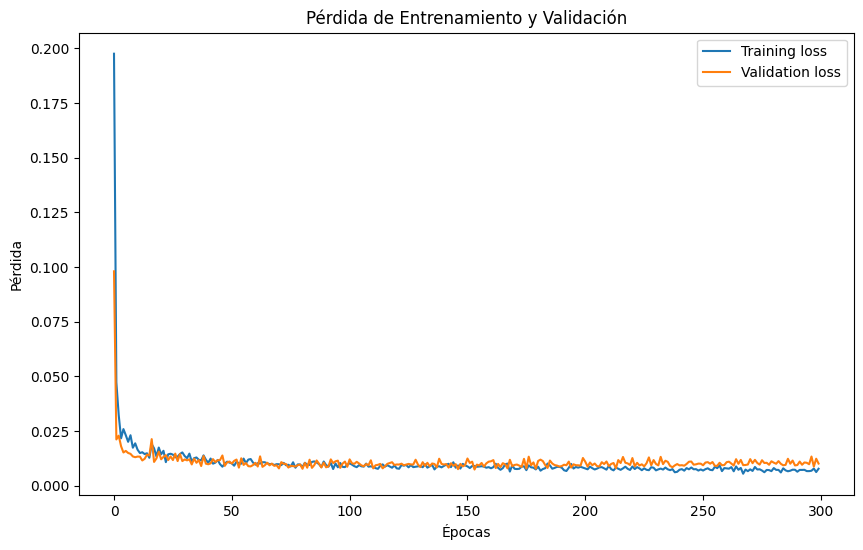

In [ ]:
# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


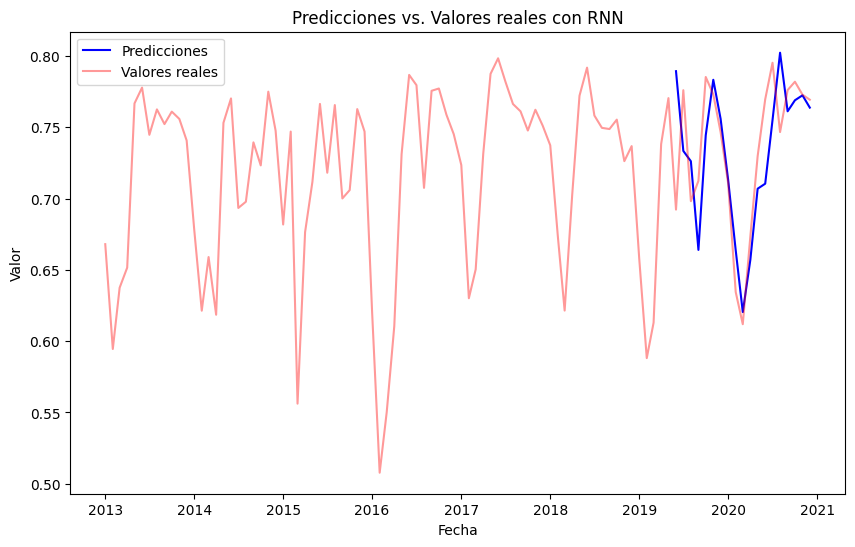

In [ ]:
y_pred_model = saved_model.predict(X_test_tensor)

# Convertir las predicciones y valores reales a su escala original
y_pred_model_inv = scaler.inverse_transform(np.concatenate((y_pred_model, np.zeros((y_pred_model.shape[0], dataset.shape[1]-1))), axis=1))[:, 0]
y_sca_inv = scaler.inverse_transform(np.concatenate((y_all, np.zeros((y_all.shape[0], dataset.shape[1]-1))), axis=1))[:, 0]

# Obtener las fechas correspondientes a las predicciones
dates = dataset.index[-len(y_pred_model):]

# Graficar predicciones vs. valores reales
plt.figure(figsize=(10, 6))
plt.plot(dates, y_pred_model_inv, label='Predicciones', color='blue')
plt.plot(dataset.index, dataset['ndvi'], label='Valores reales', color='red', alpha=0.4)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicciones vs. Valores reales con RNN')
plt.legend()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


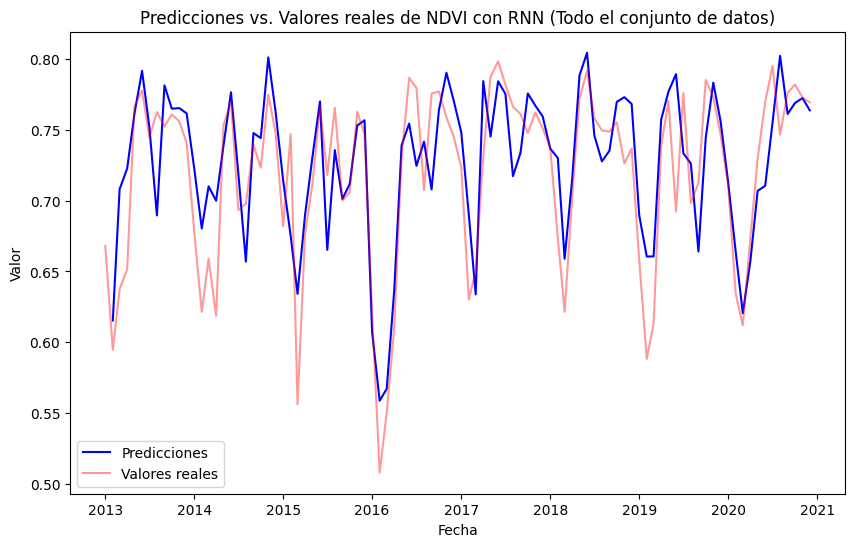

In [ ]:
# Realizar predicciones en el conjunto completo de datos
y_pred_all = saved_model.predict(X_all_tensor)

# Convertir las predicciones y valores reales a su escala original
y_pred_all_inv = scaler.inverse_transform(np.concatenate((y_pred_all, np.zeros((y_pred_all.shape[0], dataset.shape[1]-1))), axis=1))[:, 0]
y_all_inv = scaler.inverse_transform(np.concatenate((y_all.reshape(-1, 1), np.zeros((y_all.shape[0], dataset.shape[1]-1))), axis=1))[:, 0]

# Obtener las fechas correspondientes a las predicciones
all_dates = dataset.index[n_past_steps: n_past_steps + len(y_pred_all)]

# Graficar predicciones vs. valores reales en todo el conjunto de datos
plt.figure(figsize=(10, 6))
plt.plot(all_dates, y_pred_all_inv, label='Predicciones', color='blue')
plt.plot(dataset.index, dataset['ndvi'], label='Valores reales', color='red', alpha=0.4)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicciones vs. Valores reales de NDVI con RNN (Todo el conjunto de datos)')
plt.legend()
plt.show()